# Project 5: Infinite Impulse Response Filter Design
There are four classical IIR filters: (1) Butterworth (2) Chebyshev I (3) Chebyshev II (4) Elliptic. They represent four different combinations of two error approximation measures. The first measure uses the Taylor series while the other minimizes the difference between the desired and actual response over a band of frequencies. 

We will explore and compare various methods for designing IIR filters in this Project

## Objective

1. Design a 6<sup>th</sup>-order low-pass Butterworth filter.
    1. Plot the magnitude and phase responses.
    2. Plot the pole-zero representation

2. Repeat #1 for a Chebyshev I filter with a passband ripple of $1~\text{dB}$ and plot the magnitude, phase, and frequency response.

3. Repeat #1 for a Chebyshev II filter with a stopband cutoff of $0.3\pi$ and maximum stopband ripple of $30~\text{dB}$ 

4. Repeat #1 for a Ellipse filter with a passband cutoff of $0.3\pi$ and passband ripple of $1~\text{dB}$ and maximum stopband ripple of $30~\text{dB}$.

5. Read the audio file into the notebook <code>doorbell.wav</code>.
    1. Determine the upper and lower frequencies of the doorbell.
    2. Design a filter such that the lower tone is attenuated no more than $3~\text{dB}$ while the upper tone is attenuated $15~\text{dB}$.
    3. Design all four types of filter and plot the resulting spectrum.

## Solutions:

1. We load the relevent packages

In [403]:
using Plots, DSP, WAV, FFTW, Printf

<code>DSP</code> has built-in IIR filters for us to play with, so we can load in the butterworth and visualize its properties after creating a plotting function.

In [404]:
function plots(iir_filter, response)
    h, w = response
    mag = abs.(h)
    phase = atan.(imag.(h)./real.(h))

    layout_style = @layout [
                a{0.3w} [grid(1,1)
                 grid(1,1)]]

    poles = iir_filter.p
    zeros = iir_filter.z
    
    p0 = scatter(real.(poles), imag.(poles), xlim=(-2, 2), ylim=(-2,2), marker=:x, color=:red, xlabel="Real", ylabel="Imaginary", title="Pole-Zero")
    scatter!(-real.(poles), imag.(poles), xlim=(-2, 2), ylim=(-2,2), marker=:x, color=:red)
    scatter!(real.(zeros), imag.(zeros), marker=:o, color=:black)

    p1 = plot(w./w[length(w)], mag, title="Magnitude Response", xaxis=:log)
    yaxis!("Magnitude")

    p2 = plot(w./w[length(w)], phase, title="Phase Response", xaxis=:log)
    yaxis!("Phase [rad]")
    xaxis!("Normalized Frequency")

    plot(p0, p1, p2, layout = layout_style , label="", framestyle=:box)
end

plots (generic function with 1 method)

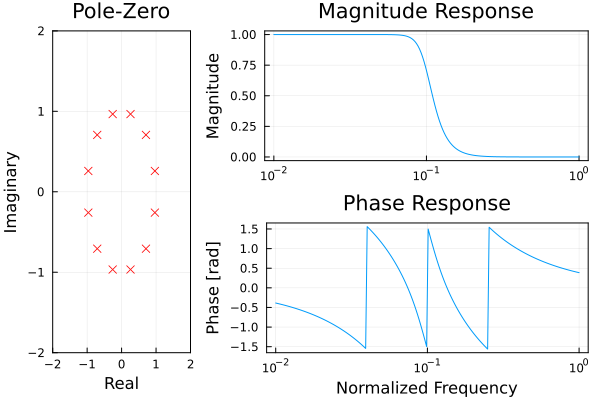

In [405]:
bwf = Butterworth(6)
plots(bwf, freqresp(bwf))


2. through 4. - We repeat the same steps as #1 while keeping the ripple parameters in mind.

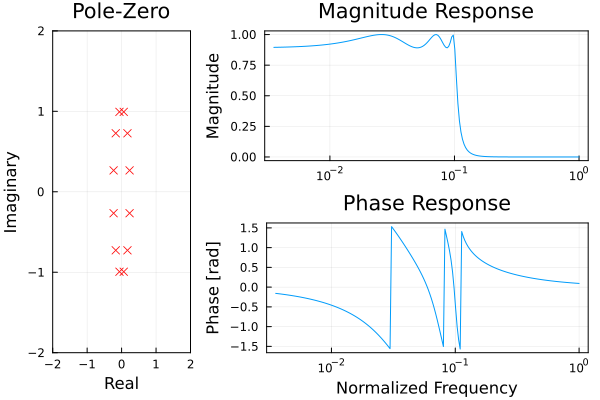

In [406]:
c1f = Chebyshev1(6, 1)
plots(c1f, freqresp(c1f))

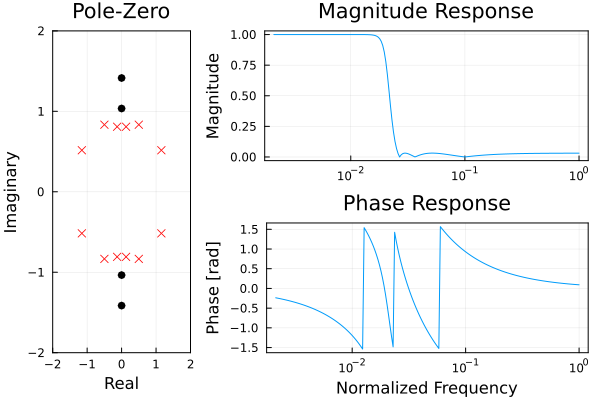

In [407]:
c2f = Chebyshev2(6, 30)
plots(c2f, freqresp(c2f))

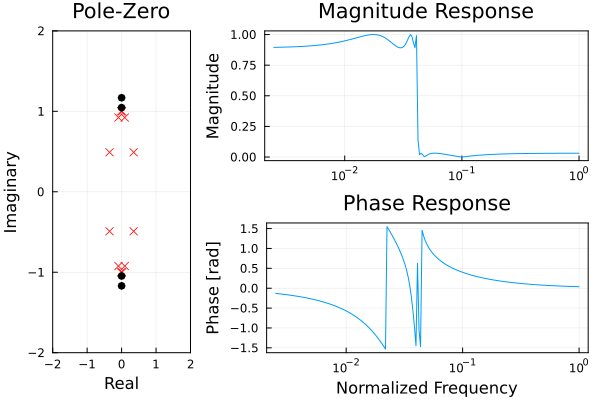

In [408]:
ef = Elliptic(6,1,30)
plots(ef, freqresp(ef))

5. Using the <code>WAV</code> package, we can load the .wav file into the worksheet and separate the channels and sample frequency

In [409]:
y, Fs = wavread("doorbell.wav")

([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], 48000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x02, 0x00, 0x80, 0xbb, 0x00, 0x00, 0x00, 0xee, 0x02, 0x00, 0x04, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x53, 0x46, 0x54, 0x08, 0x00, 0x00, 0x00, 0x46, 0x69, 0x73, 0x73, 0x69, 0x6f, 0x6e, 0x00])])

The .wav is quite long, so we truncate 1/32<sup>nd</sup> of the total sound to analyze

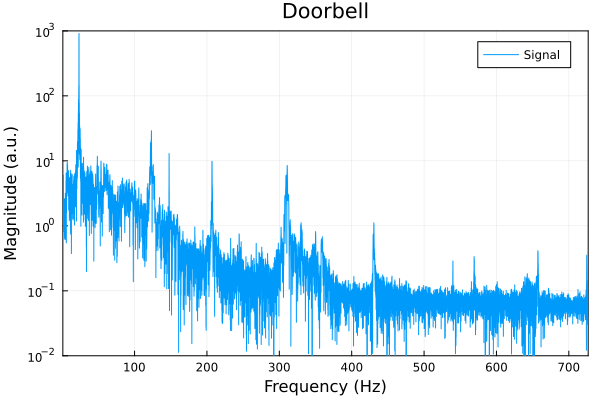

In [410]:
N = floor(Int,length(y[:,1])/32)
Y = fftshift(abs.(fft(y[1:N,1])))[floor(Int, N/2):N]
nPts = floor(Int, (N+1)/2)
ν = (1:1:nPts+1).*(Fs/32/N)

plot(ν, Y; yaxis=:log, xlim=(ν[10], ν[8000]), ylim=(1e-2, 1e3), framestyle=:box, title="Doorbell", label = "Signal")
xaxis!("Frequency (Hz)")
yaxis!("Magnitude (a.u.)")

There are five prominent bands that contribute to the doorbell sound, with the lowest frequency dominating at $23.3~\text{Hz}$ and the highest frequency visible at around $440~\text{Hz}$. The first signal is background and we will not consider it, thus the first frequency we will use is at around $120~\text{Hz}$. By normalizing this frequency range we obtain the pass- and stop-band 

In [411]:
Wp = ν[1321] / ν[length(ν)]
Ws = ν[4624] / ν[length(ν)]

@printf "Passband: %g, Stopband: %g" Wp Ws 

Passband: 0.159985, Stopband: 0.56001

To control the attenuation, we define the pass- and stop-band ripple in decibels and apply the parameters to <code>_ord</code> where <code>\_</code> represents the IIR filter type. This function returns the filter order <code>N</code> and cutoff frequency <code>$\omega$</code> given the parameters. With both the order and cutoff, we can build the appropriate IIR filters

In [412]:
Rp = 3
Rs = 15

Nb, ωb = buttord(Wp, Ws, 3, 15) ; butter = Butterworth(Nb)
N1, ω1 = cheb1ord(Wp, Ws, 3, 15); cheby1 = Chebyshev1(N1, Rp)
N2, ω2 = cheb2ord(Wp, Ws, 3, 15); cheby2 = Chebyshev2(N2, Rs)
Ne, ωe = ellipord(Wp, Ws, 3, 15); ellipt = Elliptic(Ne, Rp, Rs)

@printf "Butterworth Order: %g, Chebyshev I Order: %g, Chebyshev II Order: %g, Elliptic Order: %g" Nb N1 N2 Ne
println("")
@printf "Butterworth COfre: %g, Chebyshev I COfre: %g, Chebyshev II COfre: %g, Elliptic COfre: %g" ωb ω1 ω2 ωe

Butterworth Order: 2, Chebyshev I Order: 2, Chebyshev II Order: 2, Elliptic Order: 2
Butterworth COfre: 0.302192, Chebyshev I COfre: 0.159985, Chebyshev II COfre: 0.276831, Elliptic COfre: 0.159985

To convert the IIR filter into one that can be processed with the imported signal, we convert it into a FIR filter and filter it given the <code>a</code> and <code>b</code> coefficients. This can be done within a function that accepts the filter response (e.g. Lowpass, Highpass, Bandpass), the type of IIR filter, and the signal we wish to filter.

In [413]:
function apply_iir(response, iir_filter, signal)
    hz = convert(PolynomialRatio, digitalfilter(response, iir_filter))
    return abs.(filt(coefb(hz),coefa(hz),signal))
end

apply_iir (generic function with 1 method)

Now we generate all filtered signals and plot to compare them

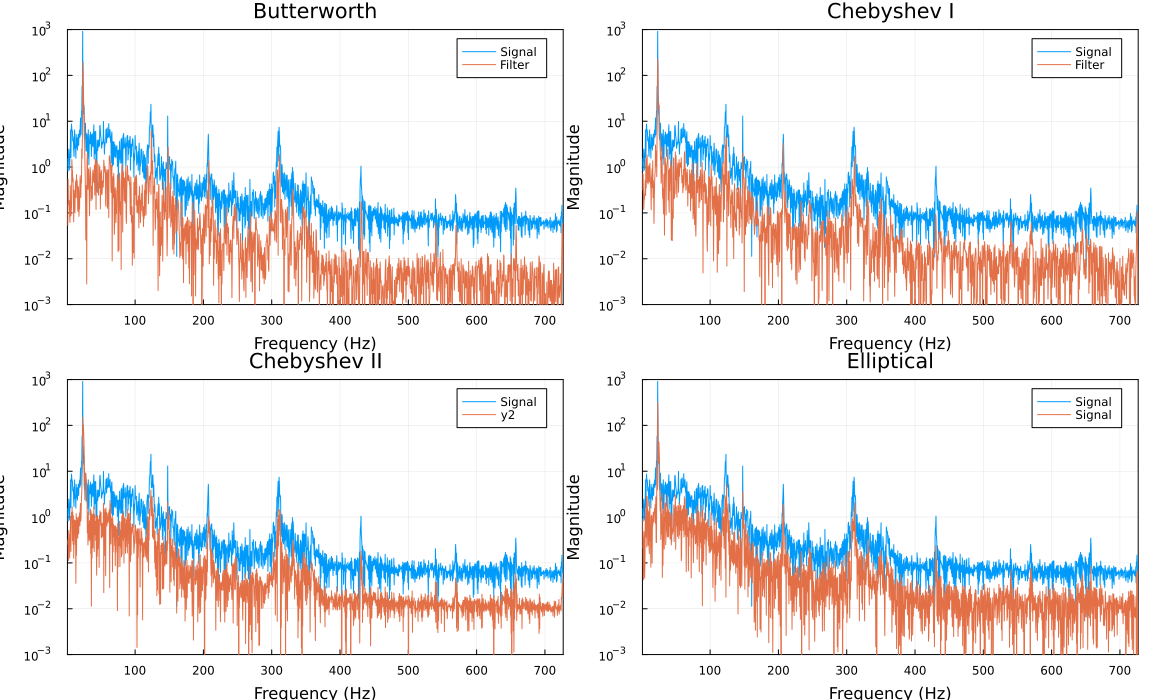

In [414]:
filt_butter = apply_iir(Bandpass(Wp, ωb), butter, Y)
filt_cheby1 = apply_iir(Bandpass(ω1, Ws), cheby1, Y)
filt_cheby2 = apply_iir(Bandpass(Wp, ω2), cheby2, Y)
filt_ellipt = apply_iir(Bandpass(ωe, Ws), ellipt, Y)

N = length(ν)
sparse = 1:5:N # To thin out the plots and make it easier to see the peaks

p1 = plot(ν[sparse], Y[sparse]; yaxis=:log, xlim=(ν[10], ν[8000]), ylim=(1e-3, 1e3), framestyle=:box, title="Butterworth", label = "Signal")
plot!(ν[sparse], filt_butter[sparse]; yaxis=:log, label = "Filter")

p2 = plot(ν[sparse], Y[sparse]; yaxis=:log, xlim=(ν[10], ν[8000]), ylim=(1e-3, 1e3), framestyle=:box, title="Chebyshev I", label = "Signal")
plot!(ν[sparse], filt_cheby1[sparse]; yaxis=:log, label = "Filter")

p3 = plot(ν[sparse], Y[sparse]; yaxis=:log, xlim=(ν[10], ν[8000]), ylim=(1e-3, 1e3), framestyle=:box, title="Chebyshev II", label = "Signal")
plot!(ν[sparse], filt_cheby2[sparse]; yaxis=:log)

p4 = plot(ν[sparse], Y[sparse]; yaxis=:log, xlim=(ν[10], ν[8000]), ylim=(1e-3, 1e3), framestyle=:box, title="Elliptical", label = "Signal")
plot!(ν[sparse], filt_ellipt[sparse]; yaxis=:log, label = "Signal")

plot!(p1, p2, p3, p4; size=(1150,700), layout = (2,2), ylabel="Magnitude", xlabel="Frequency (Hz)")
